In [5]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights
from PIL import Image

# define the EncoderCNN class
class EncoderCNN(nn.Module):
    def __init__(self,embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        #Disabled Learning from Parameters
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forword(self,images):
        features = self.resnet(images)
        features = features.View(features.size(0),-1)
        features = self.embed(features)
        return features

In [6]:
# Load the Image 
image_path = "/home/hariom/Downloads/best.jpeg"
image = Image.open(image_path).convert('RGB')

#Process the Image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image_tensor = preprocess(image).unsqueeze(0)


In [7]:
#Initialize the encoder
embed_size = 256
encoder = EncoderCNN(embed_size)

# Move encoder to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)

#set encoder to evalution mode
encoder.eval()

#Move image tensor to device
image_tensor = image_tensor.to(device)

# Forword pass the image through encoder
output = image_tensor
for name, module in encoder.resnet.named_children():
    output = module(output)
    print(f"Output after {name}: {output.shape}")

# Get the final feature vector
output = output.view(output.size(0), -1)
output = encoder.embed(output)
print(f"Final feature vector shape: {output.shape}")


Output after 0: torch.Size([1, 64, 112, 112])
Output after 1: torch.Size([1, 64, 112, 112])
Output after 2: torch.Size([1, 64, 112, 112])
Output after 3: torch.Size([1, 64, 56, 56])
Output after 4: torch.Size([1, 256, 56, 56])
Output after 5: torch.Size([1, 512, 28, 28])
Output after 6: torch.Size([1, 1024, 14, 14])
Output after 7: torch.Size([1, 2048, 7, 7])
Output after 8: torch.Size([1, 2048, 1, 1])
Final feature vector shape: torch.Size([1, 256])


In [8]:
print("embedding vector:",output)

embedding vector: tensor([[-1.8226e-01, -2.4721e-01, -3.8550e-01,  2.0363e-01,  1.8398e-01,
          2.6446e-02,  5.5502e-02, -9.1035e-02, -1.2807e-01, -7.4858e-02,
          2.3111e-01, -3.1354e-02,  2.0152e-01, -3.4426e-02, -3.8888e-02,
         -7.0802e-02,  9.5861e-02, -1.3323e-01, -1.1783e-01, -6.2632e-02,
         -1.1014e-02,  2.4264e-01, -3.5612e-01,  6.4503e-02,  6.7661e-03,
         -3.9635e-02,  1.1789e-01, -1.4392e-01, -2.0998e-01, -4.1034e-02,
          6.2076e-02, -2.5537e-02, -2.2063e-01, -1.5965e-01,  6.3087e-02,
         -3.8214e-02,  1.8421e-02,  6.0762e-02,  1.9831e-02, -1.9126e-01,
         -2.7960e-01, -2.1577e-01,  5.7790e-01,  1.9599e-01, -2.0365e-01,
          1.1673e-01,  3.5281e-01,  1.0514e-01, -1.6716e-01, -1.8648e-03,
          1.4859e-02, -2.8279e-01,  1.9769e-03, -1.1219e-01, -1.3166e-01,
          7.3973e-03, -3.0708e-01,  3.2625e-01,  1.1689e-01, -2.2516e-01,
         -1.2460e-02, -3.0880e-01, -1.6096e-01,  4.1522e-02, -4.2418e-01,
         -8.8019e-02

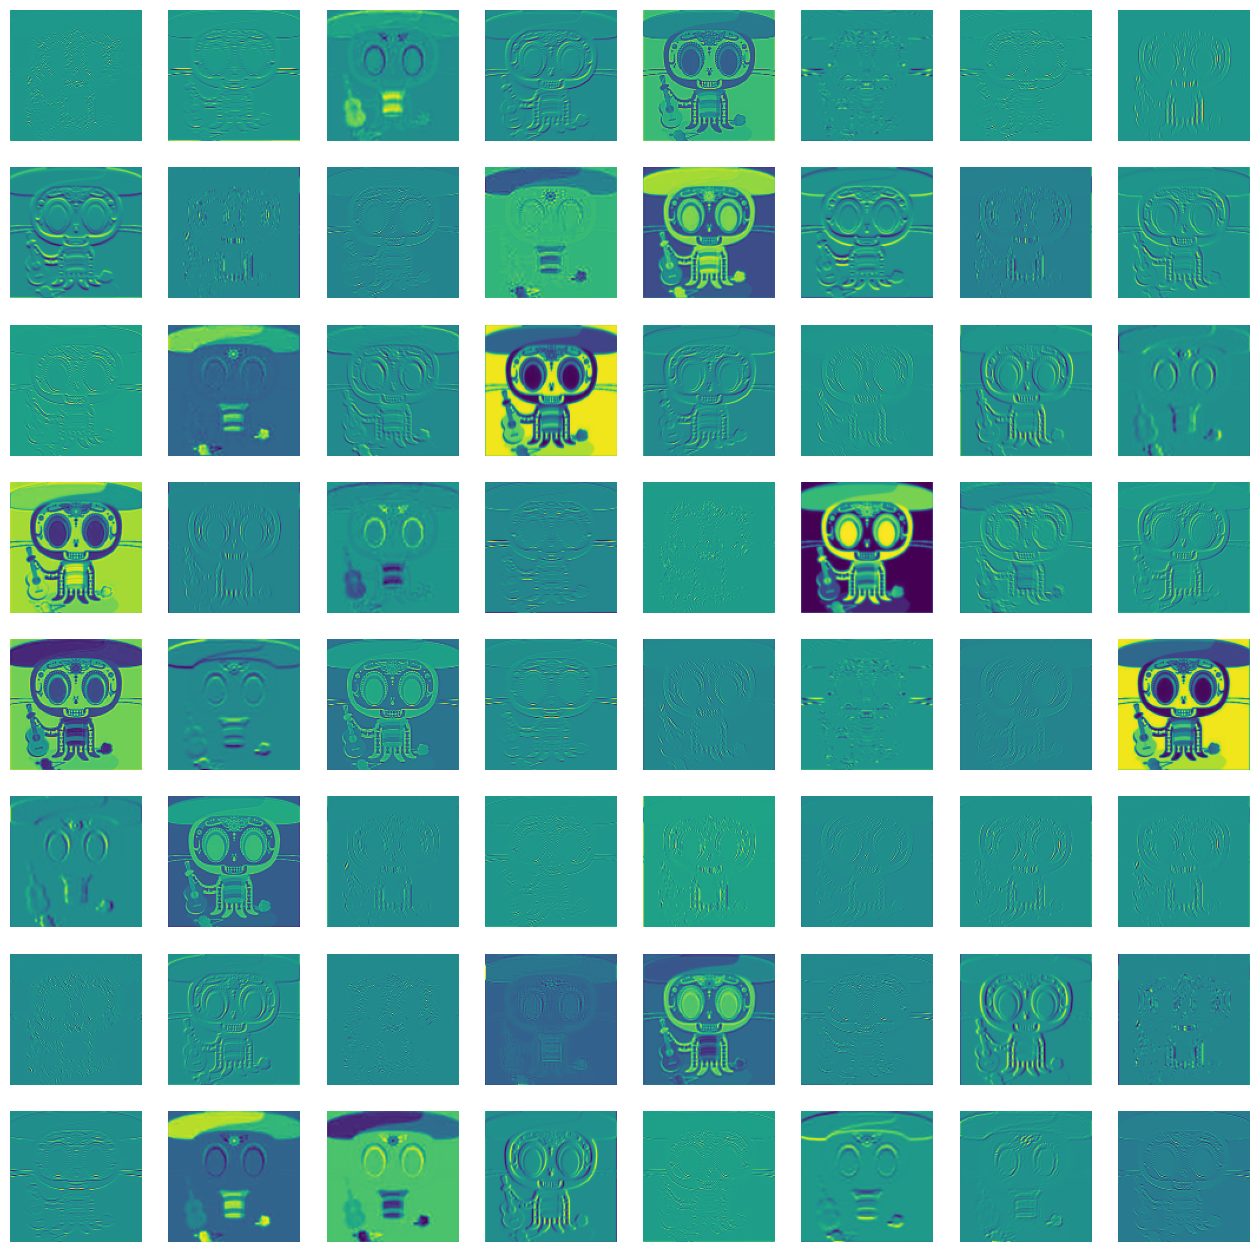

In [9]:
# Move image tensor to the device
image_tensor = image_tensor.to(device)

# Forward pass the image through the encoder
output = image_tensor
feature_maps = []  # Corrected variable name
for name, module in encoder.resnet.named_children():
    output = module(output)
    if isinstance(output, torch.Tensor):
        feature_maps.append(output.clone().detach())  # Clone and detach to prevent gradients from being tracked

# Plot all feature maps from the first layer
num_features = feature_maps[0].shape[1]
fig, axs = plt.subplots(8, 8, figsize=(16, 16))

for i in range(8):
    for j in range(8):
        feature_map = feature_maps[0][0, i * 8 + j].cpu().numpy()
        axs[i, j].imshow(feature_map, cmap='viridis')
        axs[i, j].axis('off')

plt.show()